In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import chi2_contingency

# Load the three datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Perform a left join on 'patient_id' across the three datasets
merged_data = ab_test_data.merge(app_data, on='patient_id', how='left').merge(appointments_data, on='patient_id', how='left')

# Checking for missing values (NaNs) in all three dataframes
ab_test_na = ab_test_data.isna().sum()
app_data_na = app_data.isna().sum()
appointments_data_na = appointments_data.isna().sum()
merged_data_na = merged_data.isna().sum()
ab_test_na, app_data_na, appointments_data_na, merged_data_na


(patient_id        0
 group             0
 event_name        0
 event_datetime    0
 dtype: int64,
 patient_id        0
 traffic_source    0
 device            0
 dtype: int64,
 patient_id            0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64,
 patient_id            0
 group                 0
 event_name            0
 event_datetime        0
 traffic_source        0
 device                0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64)

In [114]:
# Inspect data
print(appointments_data.info())
print(ab_test_data.info())
print(app_data.info())

# Check for missing values
print(appointments_data.isnull().sum())
print(ab_test_data.isnull().sum())
print(app_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          2678 non-null   int64 
 1   age                 2678 non-null   int64 
 2   gender              2678 non-null   object
 3   doctor_name         2678 non-null   object
 4   appointment_reason  2678 non-null   object
 5   appointment_date    2678 non-null   object
 6   appointment_status  2678 non-null   object
dtypes: int64(2), object(5)
memory usage: 146.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5660 non-null   int64 
 1   group           5660 non-null   object
 2   event_name      5660 non-null   object
 3   event_datetime  5660 non-null   object
dtypes: int64(1), object(3)
memory 

In [2]:
ab_test_data

,patient_id,group,event_name,event_datetime
0,1,Control,attended_appointment,2023-02-05 15:40:21
1,2,Test,reminder_sent,2023-05-07 09:19:13
2,2,Test,reminder_viewed,2023-05-08 04:25:10
3,2,Test,appointment_confirmed,2023-05-08 04:26:36
4,2,Test,attended_appointment,2023-05-09 10:34:13
...,...,...,...,...
5655,2673,Control,attended_appointment,2023-01-03 09:56:57
5656,2674,Control,attended_appointment,2023-07-18 10:42:54
5657,2675,Control,attended_appointment,2023-02-14 16:50:58
5658,2677,Control,attended_appointment,2023-05-21 13:26:23


Control Group Attendance Rate: 100.0
Test Group Attendance Rate: 18.07555833855145
Control Group Counts: {'Total Control Group': 869, 'Attended Control Group': 869}
Test Group Counts: {'Total Test Group': 4791, 'Attended Test Group': 866}


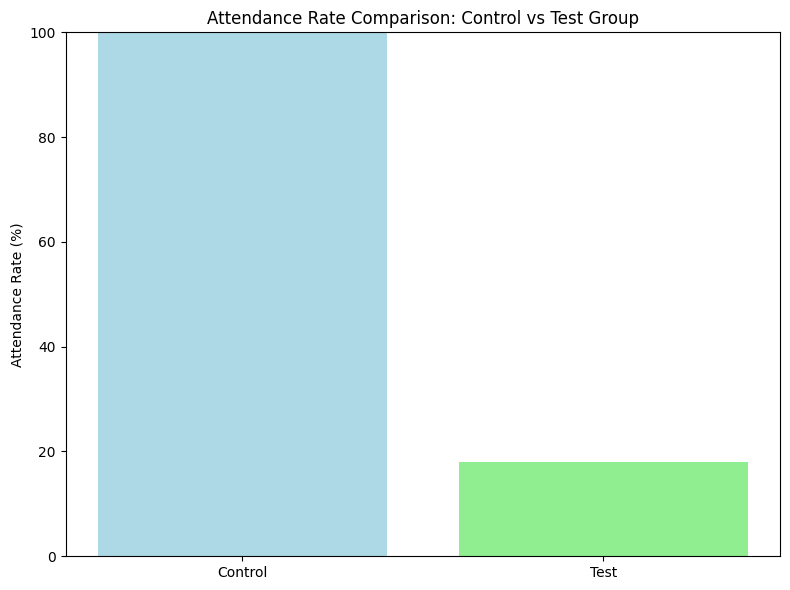

In [3]:
# Group the data
control_attended = ab_test_data[(ab_test_data['group'] == 'Control') & (ab_test_data['event_name'] == 'attended_appointment')]
test_attended = ab_test_data[(ab_test_data['group'] == 'Test') & (ab_test_data['event_name'] == 'attended_appointment')]

# Total number of entries in each group
total_control = ab_test_data[ab_test_data['group'] == 'Control'].shape[0]
total_test = ab_test_data[ab_test_data['group'] == 'Test'].shape[0]

# Number of attended appointments in each group
attended_control = control_attended.shape[0]
attended_test = test_attended.shape[0]

# Attendance rates
control_attendance_rate = (attended_control / total_control) * 100
test_attendance_rate = (attended_test / total_test) * 100

# Provide the counts for total and attended appointments in both groups
control_attendance_counts = {
    'Total Control Group': total_control,
    'Attended Control Group': attended_control
}

test_attendance_counts = {
    'Total Test Group': total_test,
    'Attended Test Group': attended_test
}

# Display the results
print("Control Group Attendance Rate:", control_attendance_rate)
print("Test Group Attendance Rate:", test_attendance_rate)

print("Control Group Counts:", control_attendance_counts)
print("Test Group Counts:", test_attendance_counts)

# Visualizing attendance rate comparison between Control and Test groups

# Data for visualization
groups = ['Control', 'Test']
attendance_rates = [control_attendance_rate, test_attendance_rate]

# Plotting the bar chart for attendance rates comparison
plt.figure(figsize=(8, 6))
plt.bar(groups, attendance_rates, color=['lightblue', 'lightgreen'])
plt.ylabel('Attendance Rate (%)')
plt.title('Attendance Rate Comparison: Control vs Test Group')
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.show()



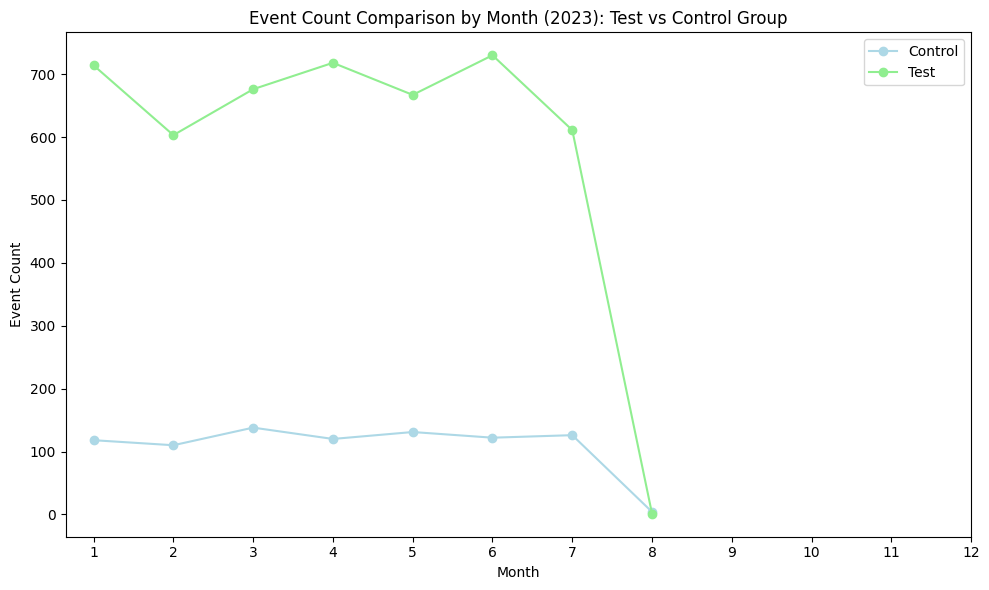

In [4]:
# Ensure 'event_datetime' is in datetime format
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Extract the year from the 'event_datetime' for time-based analysis
ab_test_data['year'] = ab_test_data['event_datetime'].dt.year
ab_test_data['month'] = ab_test_data['event_datetime'].dt.month

# Filter data for the year 2023
data_2023 = ab_test_data[ab_test_data['year'] == 2023]

# Grouping by 'group' and 'month' for 2023
monthly_data_2023 = data_2023.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2023
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Control']
plt.plot(control_data_2023['month'], control_data_2023['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Test']
plt.plot(test_data_2023['month'], test_data_2023['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2023): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


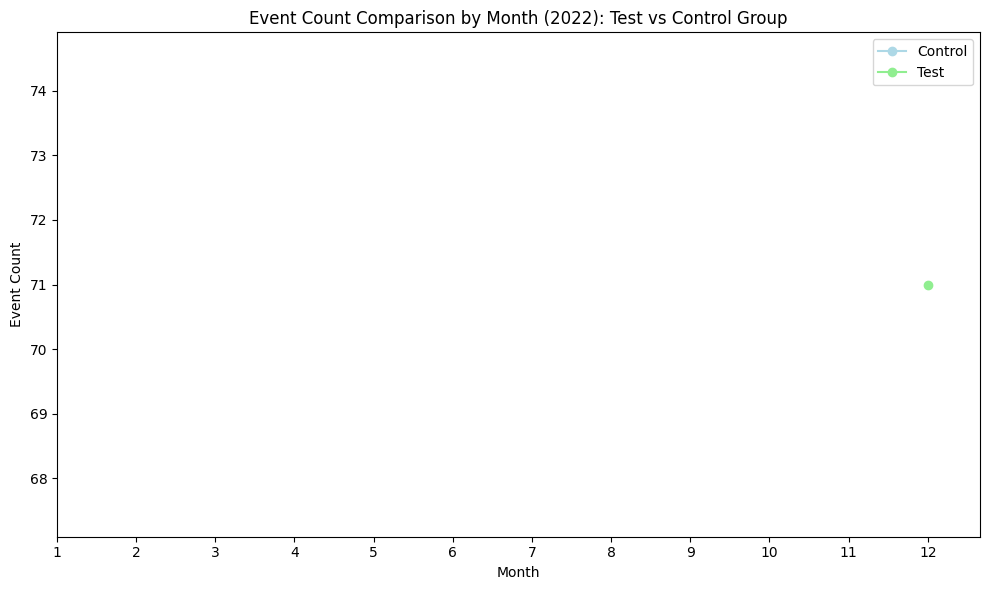

In [5]:
# Filter data for the year 2022
data_2022 = ab_test_data[ab_test_data['year'] == 2022]

# Grouping by 'group' and 'month' for 2022
monthly_data_2022 = data_2022.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2022
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Control']
plt.plot(control_data_2022['month'], control_data_2022['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Test']
plt.plot(test_data_2022['month'], test_data_2022['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2022): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [6]:
comparison_table_2022 = pd.pivot_table(monthly_data_2022, values='count', index='month', columns='group', fill_value=0).reset_index()
comparison_table_2022

group,month,Test
0,12,71.0


In [7]:
comparison_table_2023 = pd.pivot_table(monthly_data_2023, values='count', index='month', columns='group', fill_value=0).reset_index()
comparison_table_2023

group,month,Control,Test
0,1,118.0,714.0
1,2,110.0,603.0
2,3,138.0,676.0
3,4,120.0,718.0
4,5,131.0,667.0
5,6,122.0,730.0
6,7,126.0,611.0
7,8,4.0,1.0


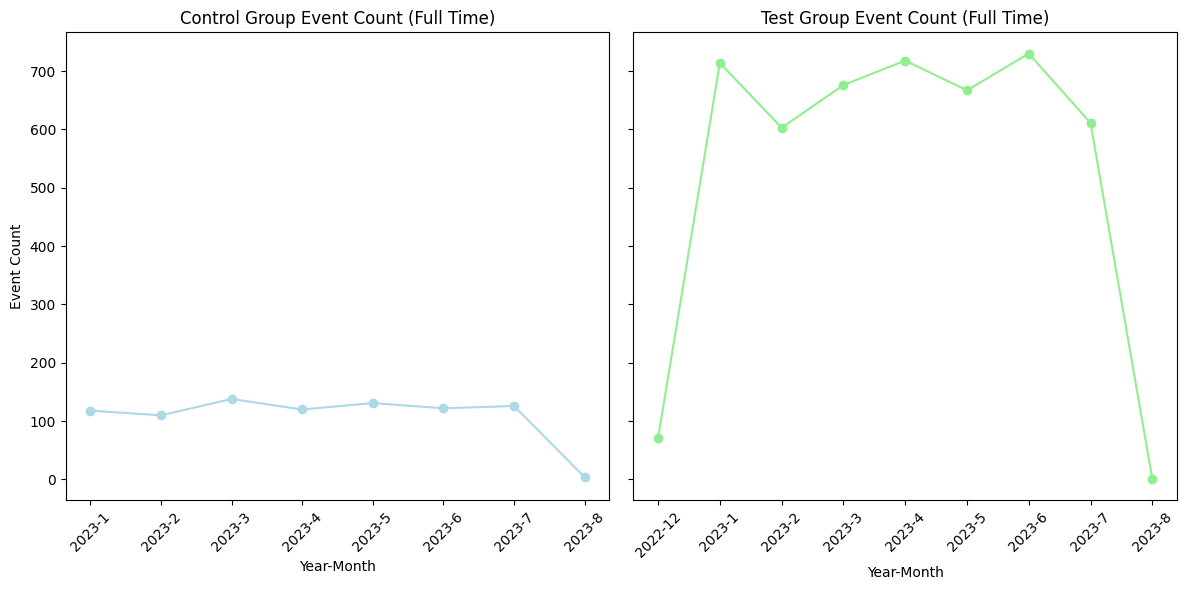

In [8]:
# Group the data by 'group', 'year', and 'month' to visualize the entire time span for Control and Test groups
full_time_data = ab_test_data.groupby(['group', 'year', 'month']).size().reset_index(name='count')

# Plot separate line charts for Control and Test groups for all available years and months
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group
control_full_time = full_time_data[full_time_data['group'] == 'Control']
axes[0].plot(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str), 
             control_full_time['count'], marker='o', color='lightblue')
axes[0].set_title('Control Group Event Count (Full Time)')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Event Count')
axes[0].set_xticks(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str))
axes[0].tick_params(axis='x', rotation=45)

# Test group
test_full_time = full_time_data[full_time_data['group'] == 'Test']
axes[1].plot(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str), 
             test_full_time['count'], marker='o', color='lightgreen')
axes[1].set_title('Test Group Event Count (Full Time)')
axes[1].set_xlabel('Year-Month')
axes[1].set_xticks(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str))
axes[1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


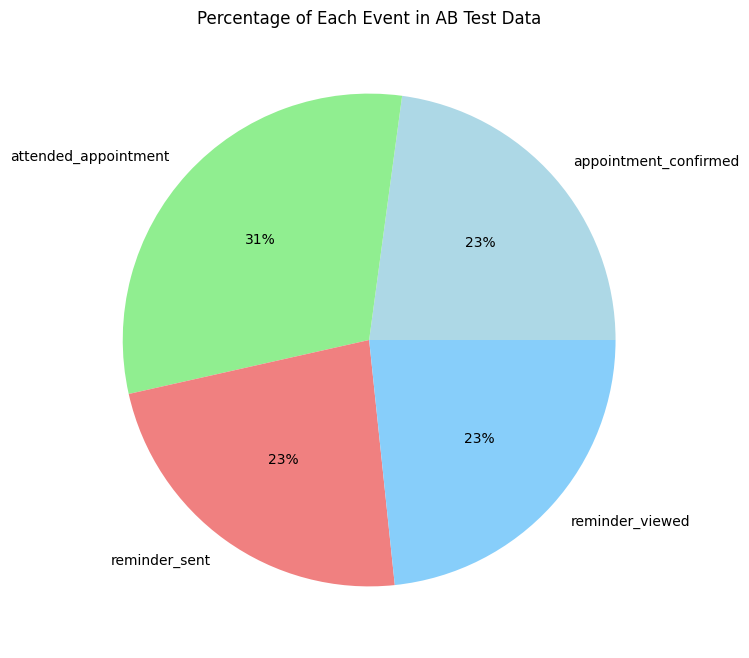

In [9]:
# Grouping by 'event_name' and calculating the count
grouped_ab_test_data = ab_test_data.groupby('event_name').size().reset_index(name='count')

# Calculate the percentage for each event
grouped_ab_test_data['percentage'] = (grouped_ab_test_data['count'] / grouped_ab_test_data['count'].sum()) * 100

# Plotting the pie chart with percentages for each event
plt.figure(figsize=(8, 8))
plt.pie(grouped_ab_test_data['percentage'], labels=grouped_ab_test_data['event_name'], autopct='%1.0f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Event in AB Test Data')

# Display the pie chart
plt.show()


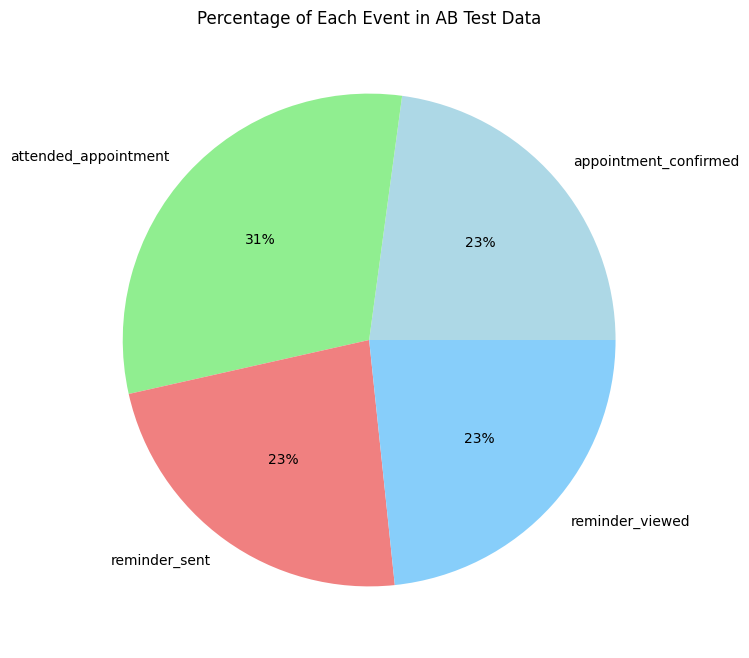

In [10]:
# Calculate the percentage of each event
grouped_ab_test_data['percentage'] = (grouped_ab_test_data['count'] / grouped_ab_test_data['count'].sum()) * 100

# # Plotting the bar chart with percentages
# plt.figure(figsize=(8, 6))
# plt.bar(grouped_ab_test_data['event_name'], grouped_ab_test_data['percentage'], color='skyblue')
# plt.xlabel('Event Name')
# plt.ylabel('Percentage (%)')
# plt.title('Percentage of Each Event in AB Test Data')
# plt.xticks(rotation=45, ha='right')

# # Display the plot
# plt.tight_layout()
# plt.show()

# Plotting the pie chart with percentages
plt.figure(figsize=(8, 8))
plt.pie(grouped_ab_test_data['percentage'], labels=grouped_ab_test_data['event_name'], autopct='%1.0f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Event in AB Test Data')

# Display the pie chart
plt.show()

In [11]:
app_data

,patient_id,traffic_source,device
0,1,Organic Search,IOS 17.4
1,2,Meta Ads,IOS 16.5
2,3,Direct,Android 8.3
3,4,Direct,Android 12.1
4,5,Direct,IOS 13.4
...,...,...,...
2673,2674,Referral,Android 9.1
2674,2675,Meta Ads,Android 12.5
2675,2676,Organic Search,Android 10.3
2676,2677,Organic Search,Android 10.1


In [12]:
pd.DataFrame(app_data['traffic_source'].unique())

,0
0,Organic Search
1,Meta Ads
2,Direct
3,Referral
4,Google Ads
5,Apple Ads


In [13]:
android_data = app_data[app_data['device'].str.lower().str.contains('android')]
ios_data = app_data[app_data['device'].str.lower().str.contains('ios')]

In [14]:
android_data.count()

patient_id        1252
traffic_source    1252
device            1252
dtype: int64

In [15]:
ios_data.count()

patient_id        1426
traffic_source    1426
device            1426
dtype: int64

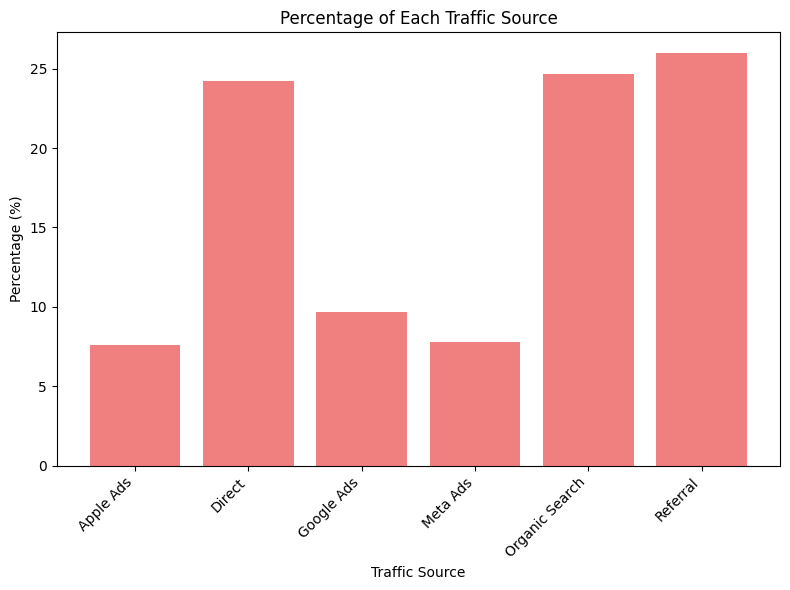

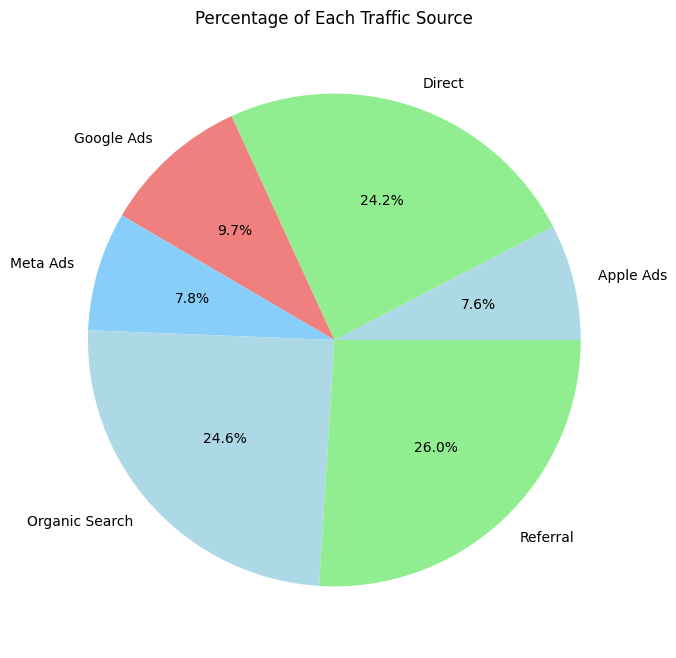

In [16]:
# Grouping the app_data by 'traffic_source' and calculating the count and percentages
grouped_traffic_source = app_data.groupby('traffic_source').size().reset_index(name='count')
grouped_traffic_source['percentage'] = (grouped_traffic_source['count'] / grouped_traffic_source['count'].sum()) * 100

# Plotting the bar chart for traffic source with percentages
plt.figure(figsize=(8, 6))
plt.bar(grouped_traffic_source['traffic_source'], grouped_traffic_source['percentage'], color='lightcoral')
plt.xlabel('Traffic Source')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Each Traffic Source')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the pie chart for traffic source
plt.figure(figsize=(8, 8))
plt.pie(grouped_traffic_source['percentage'], labels=grouped_traffic_source['traffic_source'], autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Traffic Source')
plt.show()


In [17]:
appointments_data

,patient_id,age,gender,doctor_name,appointment_reason,appointment_date,appointment_status
0,1,38,Female,Dr. Smith,Screening for COVID,2023-02-05,Attended
1,2,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
2,3,67,Female,Dr. Smith,Annual Exam,2023-01-30,Attended
3,4,63,Female,Dr. Johnson,Flu Shot,2023-04-08,Not Attended
4,5,77,Male,Dr. Jones,Allergy injection,2023-02-24,Not Attended
...,...,...,...,...,...,...,...
2673,2674,31,Female,Dr. Smith,Allergy injection,2023-07-18,Attended
2674,2675,71,Male,Dr. Jones,Annual Exam,2023-02-14,Attended
2675,2676,75,Female,Dr.Brown,Screening for COVID,2023-07-19,Not Attended
2676,2677,74,Male,Dr. Williams,Ultrasound,2023-05-21,Attended


In [18]:
# Grouping by 'appointment_reason' and counting, then ordering by count from most to least
grouped_appointments = appointments_data.groupby('appointment_reason').size().reset_index(name='count')
grouped_appointments = grouped_appointments.sort_values(by='count', ascending=False)

grouped_appointments.reset_index(drop=True)

,appointment_reason,count
0,Annual Exam,415
1,Hypertension,398
2,Ultrasound,381
3,Screening for COVID,378
4,Allergy injection,376
5,Asthma,365
6,Flu Shot,365


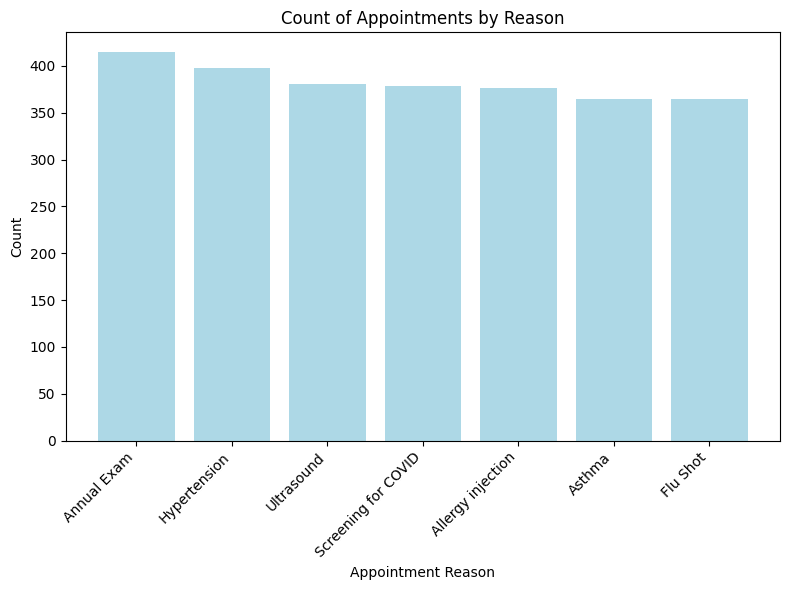

In [19]:
# Visualizing the appointment reason counts with a bar chart
plt.figure(figsize=(8, 6))
plt.bar(grouped_appointments['appointment_reason'], grouped_appointments['count'], color='lightblue')
plt.xlabel('Appointment Reason')
plt.ylabel('Count')
plt.title('Count of Appointments by Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


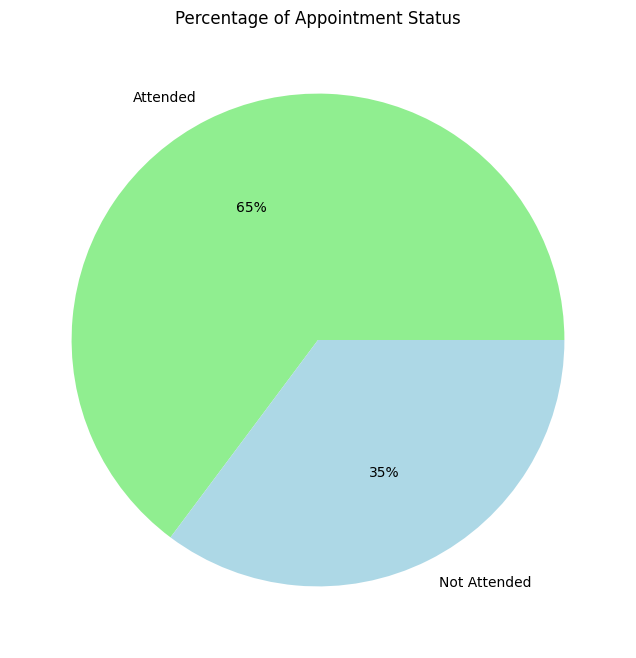

In [20]:
# Grouping by 'appointment_status' and counting, then ordering by count from highest to lowest
grouped_status = appointments_data.groupby('appointment_status').size().reset_index(name='count')
grouped_status = grouped_status.sort_values(by='count', ascending=False).reset_index(drop=True)

# Calculate the percentage for each appointment status
grouped_status['percentage'] = (grouped_status['count'] / grouped_status['count'].sum()) * 100

# Plotting the pie chart with percentages for appointment status
plt.figure(figsize=(8, 8))
plt.pie(grouped_status['percentage'], labels=grouped_status['appointment_status'], autopct='%1.0f%%', colors=['lightgreen', 'lightblue'])
plt.title('Percentage of Appointment Status')

# Display the pie chart
plt.show()


In [21]:
# Grouping by 'doctor_name' and counting the occurrences, then ordering by count from top to down
grouped_doctors = appointments_data.groupby('doctor_name').size().reset_index(name='count')
grouped_doctors = grouped_doctors.sort_values(by='count', ascending=False).reset_index(drop=True)

grouped_doctors

,doctor_name,count
0,Dr. Jones,467
1,Dr. Smith,464
2,Dr.Brown,464
3,Dr. Brown,444
4,Dr. Williams,433
5,Dr. Johnson,406


In [26]:
# Grouping by doctor_name for attended appointments
doctor_attendance_analysis = appointments_data[appointments_data['appointment_status'] == 'Attended']\
    .groupby('doctor_name').size().reset_index(name='attendance_count')

# Sorting the result to get the doctor with the highest attendance
doctor_attendance_analysis_sorted = doctor_attendance_analysis.sort_values(by='attendance_count', ascending=False)

doctor_attendance_analysis_sorted

,doctor_name,attendance_count
5,Dr.Brown,306
0,Dr. Brown,299
2,Dr. Jones,298
4,Dr. Williams,284
3,Dr. Smith,282
1,Dr. Johnson,266


In [22]:
# Define age groups and categorize patients
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
appointments_data['age_group'] = pd.cut(appointments_data['age'], bins=bins, labels=labels, right=True)

# Calculate attendance rate for each age group and round the percentage
attendance_rate = appointments_data.groupby('age_group').apply(
    lambda x: round((x['appointment_status'] == 'Attended').mean() * 100)
).reset_index(name='attendance_rate')

attendance_rate

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/4242993721.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_rate = appointments_data.groupby('age_group').apply(
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/4242993721.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attendance_rate = appointments_data.groupby('age_group').apply(


,age_group,attendance_rate
0,0-18,64
1,19-35,67
2,36-50,63
3,51-65,64
4,66-80,65
5,81-100,64


In [23]:
merged_data

,patient_id,group,event_name,event_datetime,traffic_source,device,age,gender,doctor_name,appointment_reason,appointment_date,appointment_status
0,1,Control,attended_appointment,2023-02-05 15:40:21,Organic Search,IOS 17.4,38,Female,Dr. Smith,Screening for COVID,2023-02-05,Attended
1,2,Test,reminder_sent,2023-05-07 09:19:13,Meta Ads,IOS 16.5,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
2,2,Test,reminder_viewed,2023-05-08 04:25:10,Meta Ads,IOS 16.5,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
3,2,Test,appointment_confirmed,2023-05-08 04:26:36,Meta Ads,IOS 16.5,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
4,2,Test,attended_appointment,2023-05-09 10:34:13,Meta Ads,IOS 16.5,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
...,...,...,...,...,...,...,...,...,...,...,...,...
5655,2673,Control,attended_appointment,2023-01-03 09:56:57,Direct,IOS 16.3,81,Male,Dr. Brown,Screening for COVID,2023-01-03,Attended
5656,2674,Control,attended_appointment,2023-07-18 10:42:54,Referral,Android 9.1,31,Female,Dr. Smith,Allergy injection,2023-07-18,Attended
5657,2675,Control,attended_appointment,2023-02-14 16:50:58,Meta Ads,Android 12.5,71,Male,Dr. Jones,Annual Exam,2023-02-14,Attended
5658,2677,Control,attended_appointment,2023-05-21 13:26:23,Organic Search,Android 10.1,74,Male,Dr. Williams,Ultrasound,2023-05-21,Attended


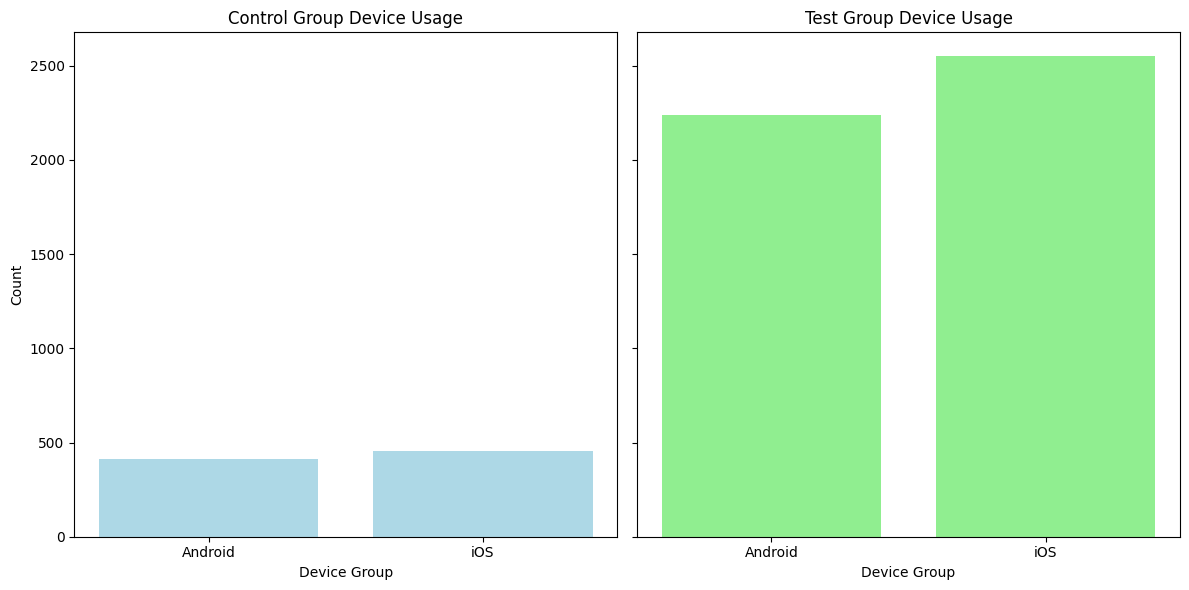

In [24]:
# Group devices into Android and iOS
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'Android' if 'android' in x else 'iOS')

# Grouping by 'group' and 'device_group' to get the counts for Control and Test groups
device_group_counts = merged_data.groupby(['group', 'device_group']).size().reset_index(name='count')

# Separate data for Control and Test groups
control_devices_grouped = device_group_counts[device_group_counts['group'] == 'Control']
test_devices_grouped = device_group_counts[device_group_counts['group'] == 'Test']

# Plotting separate bar charts for Control and Test groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group plot
axes[0].bar(control_devices_grouped['device_group'], control_devices_grouped['count'], color='lightblue')
axes[0].set_title('Control Group Device Usage')
axes[0].set_xlabel('Device Group')
axes[0].set_ylabel('Count')

# Test group plot
axes[1].bar(test_devices_grouped['device_group'], test_devices_grouped['count'], color='lightgreen')
axes[1].set_title('Test Group Device Usage')
axes[1].set_xlabel('Device Group')

# Display the plots
plt.tight_layout()
plt.show()


In [28]:
# Grouping by traffic source and filtering by "Attended" status to analyze which traffic source led to more attended appointments
attendance_by_traffic_source = merged_data[merged_data['appointment_status'] == 'Attended']\
    .groupby('traffic_source').size().reset_index(name='attendance_count')

# Sorting by attendance count from highest to lowest
attendance_by_traffic_source_sorted = attendance_by_traffic_source.sort_values(by='attendance_count', ascending=False)

# Display the results
attendance_by_traffic_source_sorted

,traffic_source,attendance_count
5,Referral,1098
4,Organic Search,1073
1,Direct,1037
2,Google Ads,406
0,Apple Ads,360
3,Meta Ads,352


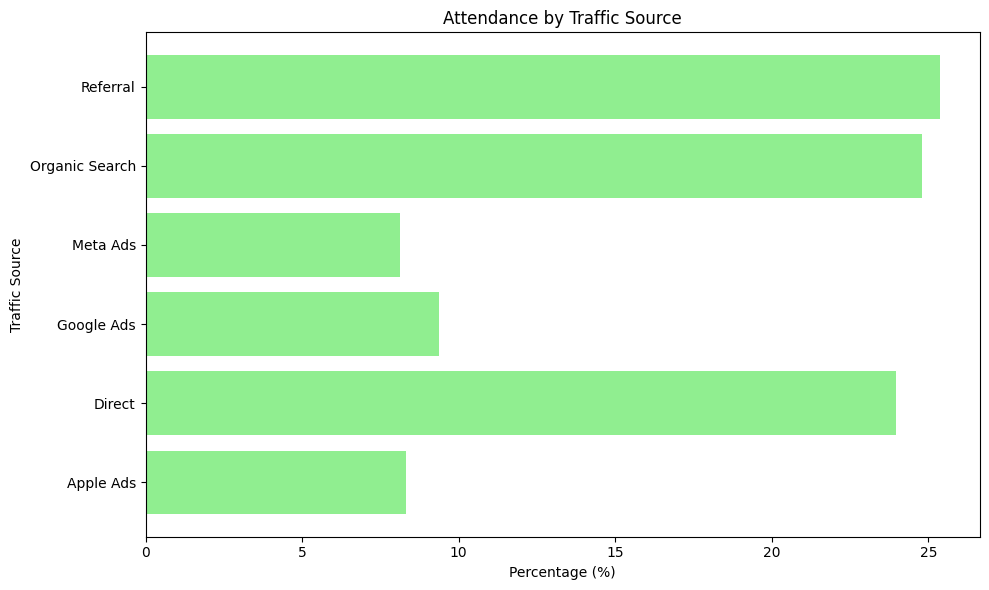

In [38]:
# Plotting a bar chart with percentages for traffic sources
plt.figure(figsize=(10, 6))
plt.barh(attendance_by_traffic_source['traffic_source'], attendance_by_traffic_source['percentage'], color='lightgreen')

plt.xlabel('Percentage (%)')
plt.ylabel('Traffic Source')
plt.title('Attendance by Traffic Source')
plt.tight_layout()
plt.show()


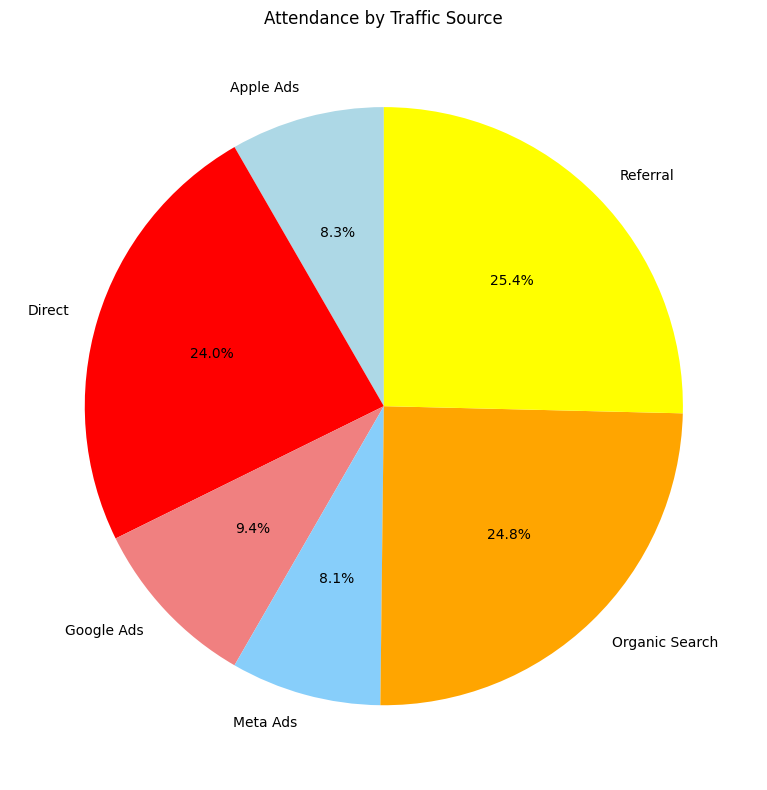

In [35]:
# Calculate percentage for each traffic source
attendance_by_traffic_source['percentage'] = (attendance_by_traffic_source['attendance_count'] / attendance_by_traffic_source['attendance_count'].sum()) * 100

# Plotting a pie chart with rounded percentages
plt.figure(figsize=(8, 8))
plt.pie(attendance_by_traffic_source['percentage'], labels=attendance_by_traffic_source['traffic_source'], 
        autopct='%1.1f%%', startangle=90, colors=['lightblue', 'red', 'lightcoral', 'lightskyblue', 'orange', 'yellow'])

plt.title('Attendance by Traffic Source')
plt.tight_layout()
plt.show()


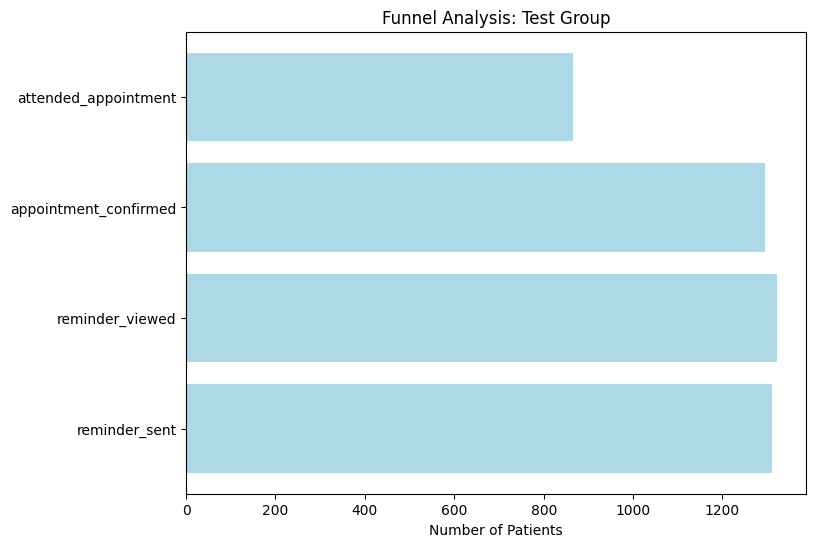

In [44]:
funnel = merged_data[merged_data['group'] == 'Test']
funnel_stages = funnel['event_name'].value_counts()

# Plot funnel
stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
values = [funnel_stages[stage] if stage in funnel_stages else 0 for stage in stages]

plt.figure(figsize=(8, 6))
plt.barh(stages, values, color='lightblue')
plt.xlabel('Number of Patients')
plt.title('Funnel Analysis: Test Group')
plt.show()


In [47]:
# First, let's combine app_data with appointments_data
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merging app_data and appointments_data on 'patient_id'
app_appointments_merged = pd.merge(app_data, appointments_data, on='patient_id', how='inner')

# Now, let's combine ab_test_data with appointments_data
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merging ab_test_data and appointments_data on 'patient_id'
ab_appointments_merged = pd.merge(ab_test_data, appointments_data, on='patient_id', how='inner')


In [48]:
app_appointments_merged

,patient_id,traffic_source,device,age,gender,doctor_name,appointment_reason,appointment_date,appointment_status
0,1,Organic Search,IOS 17.4,38,Female,Dr. Smith,Screening for COVID,2023-02-05,Attended
1,2,Meta Ads,IOS 16.5,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
2,3,Direct,Android 8.3,67,Female,Dr. Smith,Annual Exam,2023-01-30,Attended
3,4,Direct,Android 12.1,63,Female,Dr. Johnson,Flu Shot,2023-04-08,Not Attended
4,5,Direct,IOS 13.4,77,Male,Dr. Jones,Allergy injection,2023-02-24,Not Attended
...,...,...,...,...,...,...,...,...,...
2673,2674,Referral,Android 9.1,31,Female,Dr. Smith,Allergy injection,2023-07-18,Attended
2674,2675,Meta Ads,Android 12.5,71,Male,Dr. Jones,Annual Exam,2023-02-14,Attended
2675,2676,Organic Search,Android 10.3,75,Female,Dr.Brown,Screening for COVID,2023-07-19,Not Attended
2676,2677,Organic Search,Android 10.1,74,Male,Dr. Williams,Ultrasound,2023-05-21,Attended


In [52]:
# Step 1: Overall Attendance Rate
total_patients = app_appointments_merged.shape[0]
attended_patients = app_appointments_merged[app_appointments_merged['appointment_status'] == 'Attended'].shape[0]
attendance_rate = (attended_patients / total_patients) * 100
print(f"Overall Attendance Rate: {attendance_rate:.2f}%")

# Step 2: Demographic Analysis (Age and Gender)
age_analysis = app_appointments_merged.groupby('age')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)
gender_analysis = app_appointments_merged.groupby('gender')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

print("Age-wise Attendance Rate:\n", age_analysis)
print("Gender-wise Attendance Rate:\n", gender_analysis)

# Step 3: Traffic Source Analysis
traffic_source_analysis = app_appointments_merged.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)
print("Traffic Source-wise Attendance Rate:\n", traffic_source_analysis)

# Step 4: Appointment Reason Analysis
appointment_reason_analysis = app_appointments_merged.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)
print("Appointment Reason-wise Attendance Rate:\n", appointment_reason_analysis)


Overall Attendance Rate: 64.79%
Age-wise Attendance Rate:
 appointment_status  Attended  Not Attended
age                                       
10                  1.000000      0.000000
11                  0.666667      0.333333
12                  1.000000      0.000000
14                  0.000000      1.000000
15                  0.000000      1.000000
..                       ...           ...
80                  0.666667      0.333333
81                  0.661017      0.338983
94                  0.000000      1.000000
97                  0.000000      1.000000
101                 0.000000      1.000000

[74 rows x 2 columns]
Gender-wise Attendance Rate:
 appointment_status  Attended  Not Attended
gender                                    
Female              0.635031      0.364969
Male                0.659913      0.340087
Traffic Source-wise Attendance Rate:
 appointment_status  Attended  Not Attended
traffic_source                            
Apple Ads           0.676471     

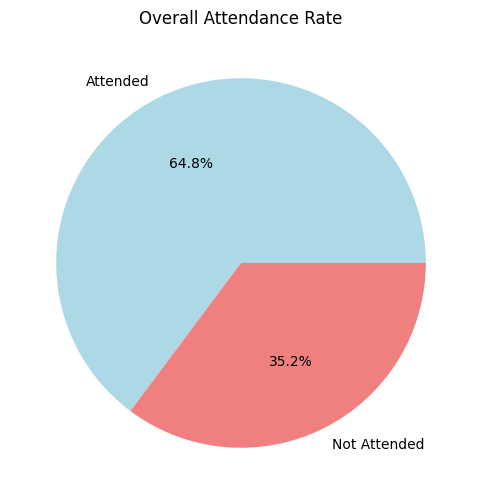

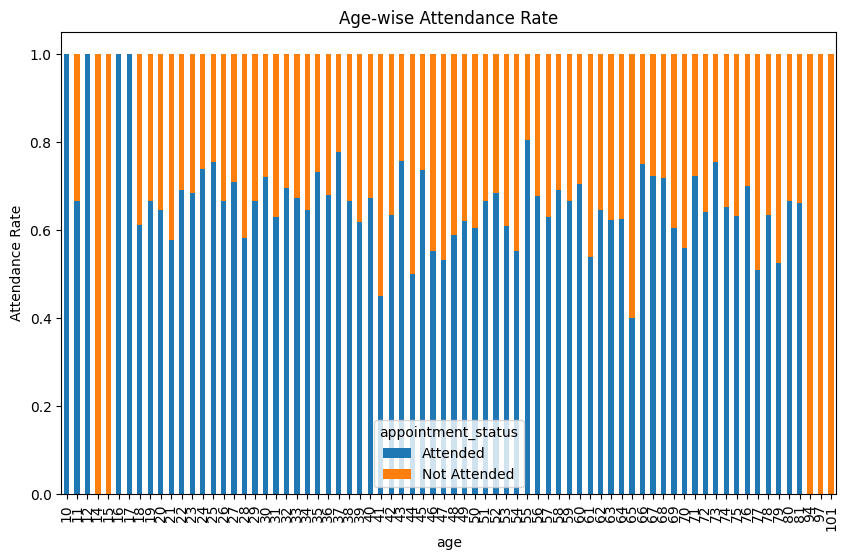

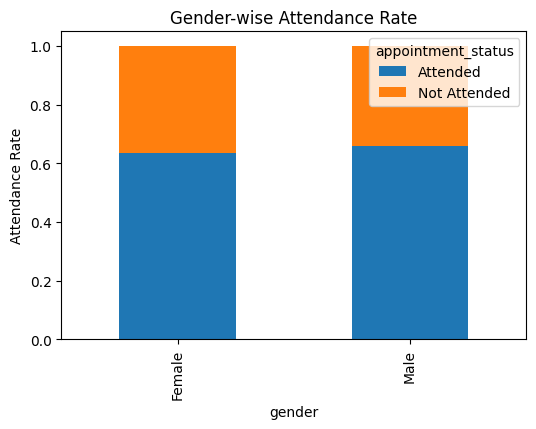

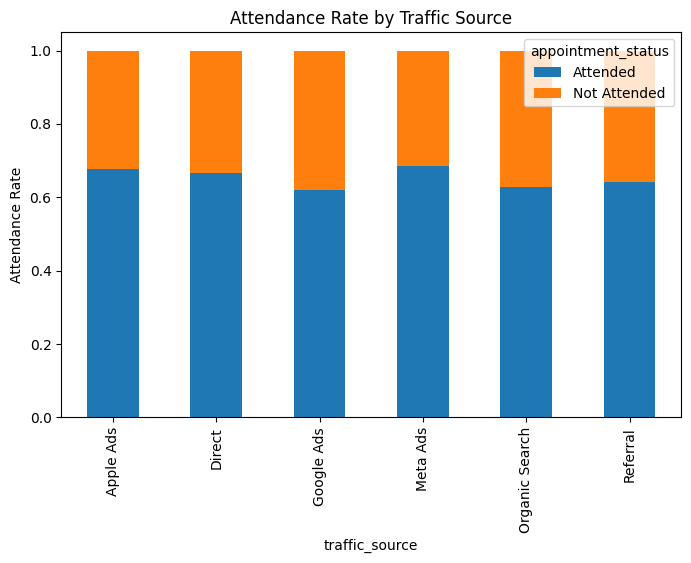

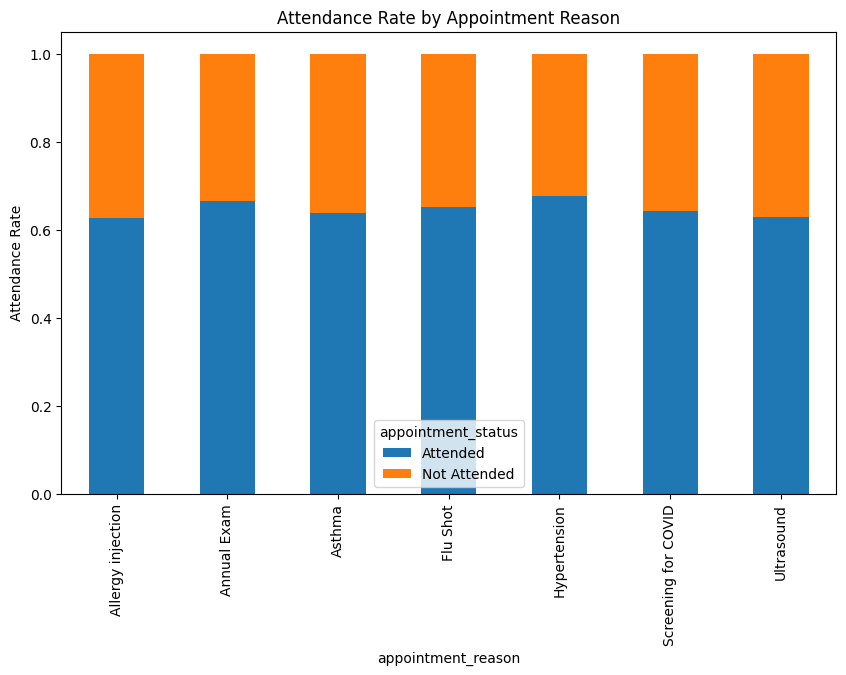

In [53]:
# Visualize overall attendance rate
plt.figure(figsize=(6, 6))
plt.pie([attendance_rate, 100 - attendance_rate], labels=['Attended', 'Not Attended'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Overall Attendance Rate')
plt.show()

# Age-wise attendance rate visualization
age_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Age-wise Attendance Rate')
plt.ylabel('Attendance Rate')
plt.show()

# Gender-wise attendance rate visualization
gender_analysis.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Gender-wise Attendance Rate')
plt.ylabel('Attendance Rate')
plt.show()

# Traffic source-wise attendance rate visualization
traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Attendance Rate by Traffic Source')
plt.ylabel('Attendance Rate')
plt.show()

# Appointment reason-wise attendance rate visualization
appointment_reason_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Attendance Rate by Appointment Reason')
plt.ylabel('Attendance Rate')
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/80472862.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_attendance = app_appointments_merged.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)


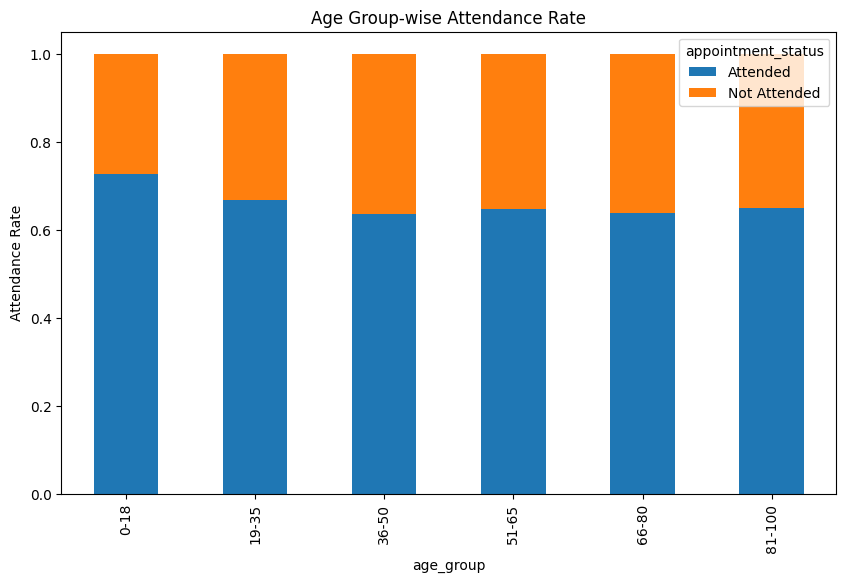

In [84]:
# Define age groups and create a new 'age_group' column
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
app_appointments_merged['age_group'] = pd.cut(app_appointments_merged['age'], bins=bins, labels=labels, right=False)

# Group by age group and appointment status
age_group_attendance = app_appointments_merged.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

# Visualize age group attendance rates
age_group_attendance.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Age Group-wise Attendance Rate')
plt.ylabel('Attendance Rate')
plt.show()

In [83]:
# Load ab_test_data
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Step 1: Group by event name to see how many users are at each stage of the funnel
funnel_counts = ab_test_data['event_name'].value_counts()

# Display the funnel stage counts
print(f"Funnel Stage Counts:\n{funnel_counts}")

# Step 2: Count unique patients who confirmed and attended the appointment
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].nunique()
attended_patients = ab_test_data[ab_test_data['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Output results
print(f"Total Confirmed: {confirmed_patients}")
print(f"Total Attended: {attended_patients}")


Funnel Stage Counts:
event_name
attended_appointment     1735
reminder_viewed          1321
reminder_sent            1310
appointment_confirmed    1294
Name: count, dtype: int64
Total Confirmed: 1294
Total Attended: 1735


In [82]:
import pandas as pd

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Step 1: Check for duplicates in reminder_sent and reminder_viewed
duplicate_sent = ab_test_data[ab_test_data['event_name'] == 'reminder_sent'].duplicated(subset='patient_id').sum()
duplicate_viewed = ab_test_data[ab_test_data['event_name'] == 'reminder_viewed'].duplicated(subset='patient_id').sum()
print(f"Duplicate 'Reminder Sent' events: {duplicate_sent}")
print(f"Duplicate 'Reminder Viewed' events: {duplicate_viewed}")

# Step 2: Find patients who have viewed the reminder but were not sent the reminder
viewed_but_not_sent = set(ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id']) - set(ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'])
total_viewed_but_not_sent = len(viewed_but_not_sent)

print(f"Total 'Reminder Viewed' without 'Reminder Sent': {total_viewed_but_not_sent}")

# Step 3: Check how many patients have 'reminder_sent' but not 'reminder_viewed'
sent_but_not_viewed = set(ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id']) - set(ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id'])
total_sent_but_not_viewed = len(sent_but_not_viewed)

print(f"Total 'Reminder Sent' without 'Reminder Viewed': {total_sent_but_not_viewed}")

# Step 4: Count funnel stages in ab_test_data
reminder_sent = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].nunique()
reminder_viewed = ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id'].nunique()
appointment_confirmed = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].nunique()
attended_appointment = ab_test_data[ab_test_data['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Step 5: Get all confirmed patients from ab_test_data
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].unique()

# Step 6: Get all attended patients from appointments_data
attended_patients = appointments_data[appointments_data['appointment_status'] == 'Attended']['patient_id'].unique()

# Step 7: Find patients who confirmed but did not attend
confirmed_but_not_attended = set(confirmed_patients) - set(attended_patients)

# Step 8: Find patients who attended but were not sent a reminder
reminder_sent_patients = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].unique()
attended_without_reminder = set(attended_patients) - set(reminder_sent_patients)

# Step 9: Count patients who were sent a reminder
total_sent_reminder = len(reminder_sent_patients)

# Output results with funnel stages
total_confirmed = len(confirmed_patients)
total_attended = len(attended_patients)
total_confirmed_but_not_attended = len(confirmed_but_not_attended)
total_attended_without_reminder = len(attended_without_reminder)

# Print funnel stages and additional results
print(f"Reminder Sent: {reminder_sent}")
print(f"Reminder Viewed: {reminder_viewed}")
print(f"Appointment Confirmed: {appointment_confirmed}")
print(f"Attended Appointment: {attended_appointment}")

print(f"Total Sent Reminder: {total_sent_reminder}")
print(f"Total Confirmed: {total_confirmed}")
print(f"Total Attended: {total_attended}")
print(f"Total Confirmed but Not Attended: {total_confirmed_but_not_attended}")
print(f"Total Attended but Not Sent Reminder: {total_attended_without_reminder}")

# Explanation for discrepancy
if total_viewed_but_not_sent > 0:
    print(f"\nNote: {total_viewed_but_not_sent} patients viewed the reminder but were not recorded as having been sent a reminder. This may indicate missing or incomplete data.")


Duplicate 'Reminder Sent' events: 0
Duplicate 'Reminder Viewed' events: 0
Total 'Reminder Viewed' without 'Reminder Sent': 11
Total 'Reminder Sent' without 'Reminder Viewed': 0
Reminder Sent: 1310
Reminder Viewed: 1321
Appointment Confirmed: 1294
Attended Appointment: 1735
Total Sent Reminder: 1310
Total Confirmed: 1294
Total Attended: 1735
Total Confirmed but Not Attended: 428
Total Attended but Not Sent Reminder: 876

Note: 11 patients viewed the reminder but were not recorded as having been sent a reminder. This may indicate missing or incomplete data.


In [85]:
# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Step 1: Get all confirmed patients from ab_test_data
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].unique()

# Step 2: Get all attended patients from appointments_data
attended_patients = appointments_data[appointments_data['appointment_status'] == 'Attended']['patient_id'].unique()

# Step 3: Find patients who confirmed but did not attend
confirmed_but_not_attended = set(confirmed_patients) - set(attended_patients)

# Step 4: Find patients who attended but were not sent a reminder
reminder_sent_patients = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].unique()
attended_without_reminder = set(attended_patients) - set(reminder_sent_patients)

# Step 5: Count patients who were sent a reminder
total_sent_reminder = len(reminder_sent_patients)

# Output results
total_confirmed = len(confirmed_patients)
total_attended = len(attended_patients)
total_confirmed_but_not_attended = len(confirmed_but_not_attended)
total_attended_without_reminder = len(attended_without_reminder)

print(f"Total Sent Reminder: {total_sent_reminder}")
print(f"Total Confirmed: {total_confirmed}")
print(f"Total Attended: {total_attended}")
print(f"Total Confirmed but Not Attended: {total_confirmed_but_not_attended}")
print(f"Total Attended but Not Sent Reminder: {total_attended_without_reminder}")


Total Sent Reminder: 1310
Total Confirmed: 1294
Total Attended: 1735
Total Confirmed but Not Attended: 428
Total Attended but Not Sent Reminder: 876


In [49]:
ab_appointments_merged

,patient_id,group,event_name,event_datetime,age,gender,doctor_name,appointment_reason,appointment_date,appointment_status
0,1,Control,attended_appointment,2023-02-05 15:40:21,38,Female,Dr. Smith,Screening for COVID,2023-02-05,Attended
1,2,Test,reminder_sent,2023-05-07 09:19:13,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
2,2,Test,reminder_viewed,2023-05-08 04:25:10,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
3,2,Test,appointment_confirmed,2023-05-08 04:26:36,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
4,2,Test,attended_appointment,2023-05-09 10:34:13,53,Male,Dr. Brown,Ultrasound,2023-05-09,Attended
...,...,...,...,...,...,...,...,...,...,...
5655,2673,Control,attended_appointment,2023-01-03 09:56:57,81,Male,Dr. Brown,Screening for COVID,2023-01-03,Attended
5656,2674,Control,attended_appointment,2023-07-18 10:42:54,31,Female,Dr. Smith,Allergy injection,2023-07-18,Attended
5657,2675,Control,attended_appointment,2023-02-14 16:50:58,71,Male,Dr. Jones,Annual Exam,2023-02-14,Attended
5658,2677,Control,attended_appointment,2023-05-21 13:26:23,74,Male,Dr. Williams,Ultrasound,2023-05-21,Attended


In [101]:
# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']


funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter for relevant stages and group by event_name to count unique patient_id's at each stage
funnel_counts = test_group[test_group['event_name'].isin(funnel_stages)]\
    .groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

funnel_counts


event_name
reminder_sent            1310
reminder_viewed          1321
appointment_confirmed    1294
attended_appointment      866
Name: patient_id, dtype: int64

In [107]:
# Load the dataset
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for only 'Test' and 'Control' groups
test_group = ab_test_data[ab_test_data['group'] == 'Test']
control_group = ab_test_data[ab_test_data['group'] == 'Control']

# Step 1: Create a binary outcome for appointment confirmations (1 = confirmed, 0 = not confirmed)
# Assuming you have an event 'appointment_confirmed' to mark confirmed appointments

test_group['confirmed'] = test_group['event_name'].apply(lambda x: 1 if x == 'appointment_confirmed' else 0)
control_group['confirmed'] = control_group['event_name'].apply(lambda x: 1 if x == 'appointment_confirmed' else 0)

# Step 2: Calculate the number of confirmed appointments for both groups
test_confirmations = test_group['confirmed'].sum()
control_confirmations = control_group['confirmed'].sum()

# Total number of patients in each group
test_total = test_group['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()

# Step 3: Create a contingency table for Chi-Square test
contingency_table = [[test_confirmations, test_total - test_confirmations],
                     [control_confirmations, control_total - control_confirmations]]

# Step 4: Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Test Group Confirmations: {test_confirmations}/{test_total} ({(test_confirmations/test_total)*100:.2f}%)")
print(f"Control Group Confirmations: {control_confirmations}/{control_total} ({(control_confirmations/control_total)*100:.2f}%)")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

# Interpretation: if p < 0.05, the difference in confirmation rates is statistically significant
if p < 0.05:
    print("The difference in confirmation rates between the Test and Control groups is statistically significant.")
else:
    print("There is no statistically significant difference in confirmation rates between the Test and Control groups.")


Test Group Confirmations: 1294/1321 (97.96%)
Control Group Confirmations: 0/869 (0.00%)
Chi-Square Statistic: 2076.5438919116614
P-value: 0.0
The difference in confirmation rates between the Test and Control groups is statistically significant.


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/982163535.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group['confirmed'] = test_group['event_name'].apply(lambda x: 1 if x == 'appointment_confirmed' else 0)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/982163535.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group['confirmed'] = control_group['event_name'].apply(lambda x: 1 if x == 'appointment_confirmed' else 0)


In [110]:
# Filter the test and control groups
test_group = ab_appointments_merged[ab_appointments_merged['group'] == 'Test']
control_group = ab_appointments_merged[ab_appointments_merged['group'] == 'Control']

# Count the number of confirmed appointments in both groups
# Step 1: Filter for 'appointment_confirmed' in each group
test_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed'].shape[0]
test_total = test_group['patient_id'].nunique()

control_confirmed = control_group[control_group['event_name'] == 'appointment_confirmed'].shape[0]
control_total = control_group['patient_id'].nunique()

# Calculate unconfirmed appointments
test_unconfirmed = test_total - test_confirmed
control_unconfirmed = control_total - control_confirmed

# Step 2: Create the contingency table
contingency_table = np.array([[test_confirmed, test_unconfirmed],
                              [control_confirmed, control_unconfirmed]])

# Step 3: Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Step 4: Calculate Risk Ratio (RR)
epsilon = 1e-10  # to avoid division by zero
risk_test = test_confirmed / test_total
risk_control = (control_confirmed + epsilon) / control_total
risk_ratio = risk_test / risk_control

# Output results
print(f"Test Group Confirmations: {test_confirmed}/{test_total} ({(risk_test * 100):.2f}%)")
print(f"Control Group Confirmations: {control_confirmed}/{control_total} ({(risk_control * 100):.2f}%)")
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Risk Ratio (RR): {risk_ratio}")


Test Group Confirmations: 1294/1321 (97.96%)
Control Group Confirmations: 0/869 (0.00%)
Chi-Square Statistic: 2076.5438919116614
P-value: 0.0
Risk Ratio (RR): 8512384557153.671


In [111]:
from scipy.stats import chi2_contingency

# Filter the test and control groups
test_group = ab_test_data[ab_test_data['group'] == 'Test']
control_group = ab_test_data[ab_test_data['group'] == 'Control']

# Count attendance in both groups (attended and not attended)
test_attended = test_group[test_group['event_name'] == 'attended_appointment'].shape[0]
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['event_name'] == 'attended_appointment'].shape[0]
control_total = control_group['patient_id'].nunique()

# Calculate not attended (total - attended)
test_not_attended = test_total - test_attended
control_not_attended = control_total - control_attended

# Create contingency table for Chi-Square test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Calculate the attendance rate for both groups
attendance_rate_test = (test_attended / test_total) * 100
attendance_rate_control = (control_attended / control_total) * 100

# Output results
chi2_stat, p_val, attendance_rate_test, attendance_rate_control


(np.float64(375.71990092116187),
 np.float64(1.063701566424743e-83),
 65.55639666919001,
 100.0)

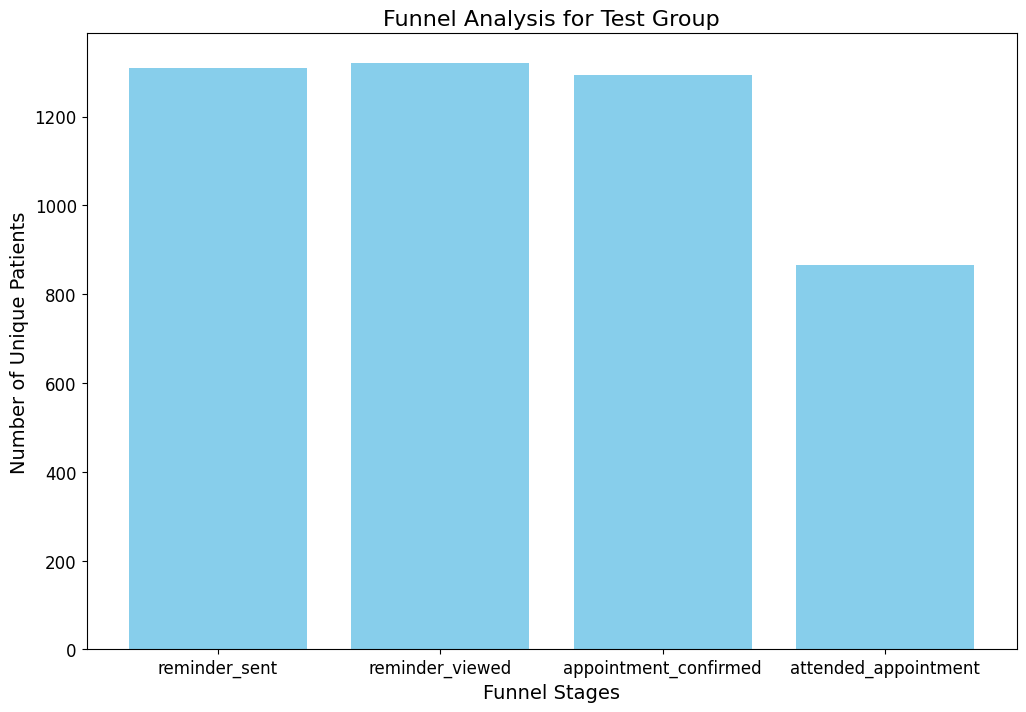

In [103]:
# Load actual dataset
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Define the funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter for relevant stages and group by event_name to count unique patient_id's at each stage
funnel_counts = test_group[test_group['event_name'].isin(funnel_stages)]\
    .groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

# Visualization - Extended size funnel plot
plt.figure(figsize=(12, 8))  # Extended figure size for larger plot
plt.bar(funnel_counts.index, funnel_counts.values, color='skyblue')
plt.xlabel('Funnel Stages', fontsize=14)
plt.ylabel('Number of Unique Patients', fontsize=14)
plt.title('Funnel Analysis for Test Group', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [115]:
from scipy.stats import chi2_contingency

# Filter for Test and Control groups
test_group = ab_test_data[ab_test_data['group'] == 'Test']
control_group = ab_test_data[ab_test_data['group'] == 'Control']

# Count confirmed appointments
test_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']['patient_id'].nunique()
control_confirmed = control_group[control_group['event_name'] == 'appointment_confirmed']['patient_id'].nunique()

# Total patients in each group
test_total = test_group['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()

# Create contingency table
contingency_table = [[test_confirmed, test_total - test_confirmed],
                     [control_confirmed, control_total - control_confirmed]]

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Test Group Confirmations: {test_confirmed}/{test_total}")
print(f"Control Group Confirmations: {control_confirmed}/{control_total}")
print(f"Chi-Square Statistic: {chi2_stat}, P-value: {p_val}")


Test Group Confirmations: 1294/1321
Control Group Confirmations: 0/869
Chi-Square Statistic: 2076.5438919116614, P-value: 0.0


In [116]:
# Calculate time difference between reminder_viewed and appointment_confirmed
test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])
viewed_confirmed = test_group[test_group['event_name'].isin(['reminder_viewed', 'appointment_confirmed'])]
viewed_confirmed = viewed_confirmed.sort_values(by=['patient_id', 'event_datetime'])
viewed_confirmed['time_diff'] = viewed_confirmed.groupby('patient_id')['event_datetime'].diff()

# Calculate the proportion of patients confirming within 1 hour
within_1_hour = viewed_confirmed[viewed_confirmed['time_diff'].dt.total_seconds() <= 3600]
confirmation_rate_1_hour = within_1_hour['patient_id'].nunique() / test_group['patient_id'].nunique()

print(f"Confirmation Rate within 1 hour: {confirmation_rate_1_hour}")


Confirmation Rate within 1 hour: 0.9742619227857684


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/2594446136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])


traffic_source
Apple Ads         138
Direct            433
Google Ads        161
Meta Ads          143
Organic Search    414
Referral          446
Name: patient_id, dtype: int64


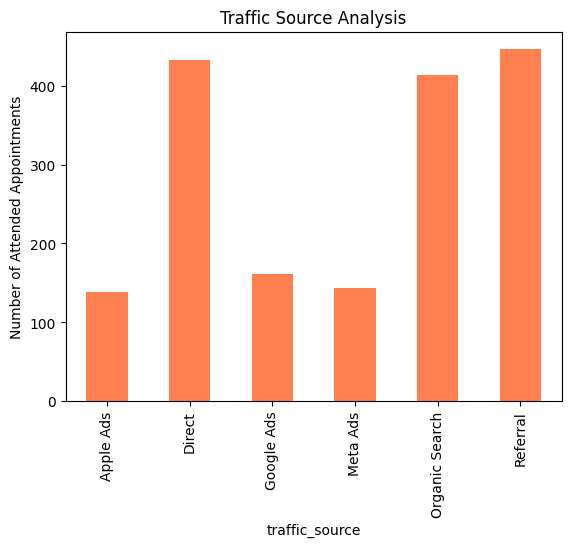

In [118]:
# Merge app_data with appointments_data to analyze traffic sources
merged_data = pd.merge(app_data, appointments_data, on='patient_id')

# Group by traffic source and count attended appointments
traffic_source_analysis = merged_data[merged_data['appointment_status'] == 'Attended'] \
    .groupby('traffic_source')['patient_id'].nunique()

print(traffic_source_analysis)

# Plot the results
traffic_source_analysis.plot(kind='bar', color='coral')
plt.title('Traffic Source Analysis')
plt.ylabel('Number of Attended Appointments')
plt.show()


In [128]:
import pandas as pd
from scipy.stats import fisher_exact
import numpy as np

# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count attendance in both groups (attended and not attended)
test_attended = test_group[test_group['appointment_status'] == 'Attended'].shape[0]
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended'].shape[0]
control_total = control_group['patient_id'].nunique()

# Ensure that totals are non-negative and handle edge cases
test_attended = max(test_attended, 0)
control_attended = max(control_attended, 0)

test_not_attended = max(test_total - test_attended, 0)
control_not_attended = max(control_total - control_attended, 0)

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


Test Group Attendance Rate: 261.70%
Control Group Attendance Rate: 100.00%
Fisher's Exact Test P-value: 1.0


In [ ]:
import pandas as pd
from scipy.stats import fisher_exact
import numpy as np

# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count attendance in both groups (attended and not attended)
test_attended = test_group[test_group['appointment_status'] == 'Attended'].shape[0]
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended'].shape[0]
control_total = control_group['patient_id'].nunique()

# Ensure that totals are non-negative and handle edge cases
test_attended = max(test_attended, 0)
control_attended = max(control_attended, 0)

test_not_attended = max(test_total - test_attended, 0)
control_not_attended = max(control_total - control_attended, 0)

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


Test Group Attendance Rate: 261.70%
Control Group Attendance Rate: 100.00%
Fisher's Exact Test P-value: 1.0


In [131]:
# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count unique patients who attended in both groups
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()

# Calculate not attended (total - attended)
test_not_attended = test_total - test_attended
control_not_attended = control_total - control_attended

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


Test Group Attendance Rate: 65.56%
Control Group Attendance Rate: 100.00%
Fisher's Exact Test P-value: 3.385311745552254e-117


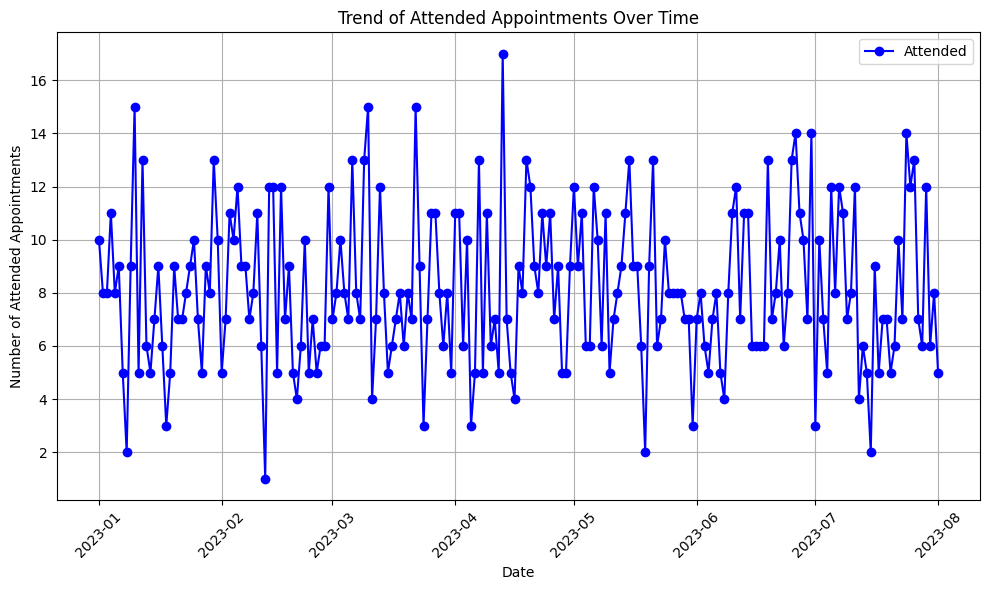

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the appointments data
appointments_data = pd.read_csv('data/appointments_data.csv')

# Convert appointment_date to datetime format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Calculate the trend of attended appointments over time
attended_trend = appointments_data[appointments_data['appointment_status'] == 'Attended']\
    .groupby('appointment_date').size()

# Plot the line chart for attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(attended_trend.index, attended_trend.values, marker='o', linestyle='-', color='blue', label='Attended')
plt.xlabel('Date')
plt.ylabel('Number of Attended Appointments')
plt.title('Trend of Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()



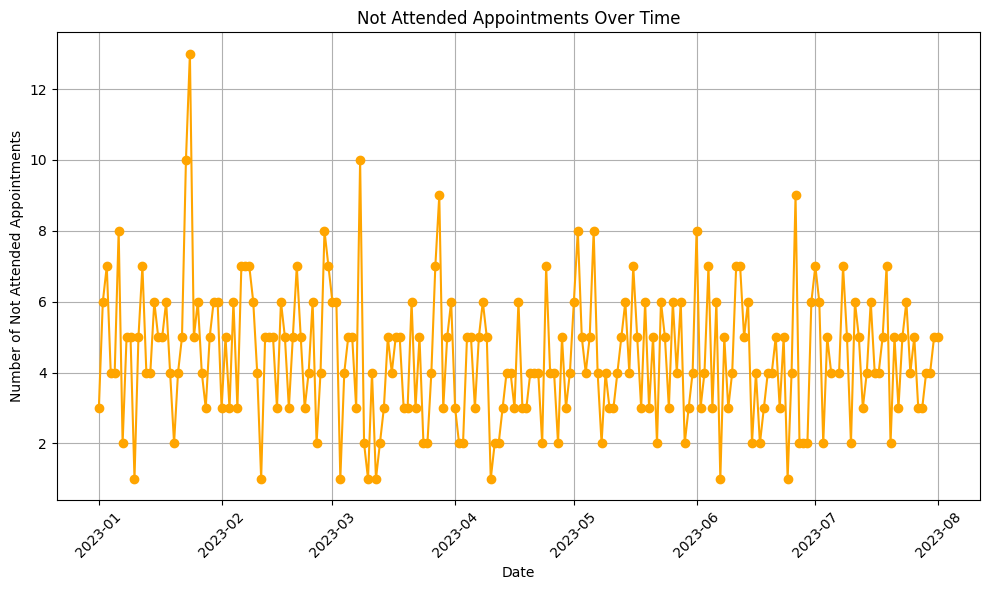

In [135]:
# Let's calculate the non-attendance over the entire time period and fix the chart to display all dates

# First, calculate the number of not attended appointments over time
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Filter for not attended appointments
not_attended_data = appointments_data[appointments_data['appointment_status'] != 'Attended']

# Group by appointment date to count not attended appointments
not_attended_over_time = not_attended_data.groupby('appointment_date').size()

# Plotting the line chart for non-attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(not_attended_over_time.index, not_attended_over_time.values, label="Not Attended", color='orange', marker='o')
plt.title('Not Attended Appointments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Not Attended Appointments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


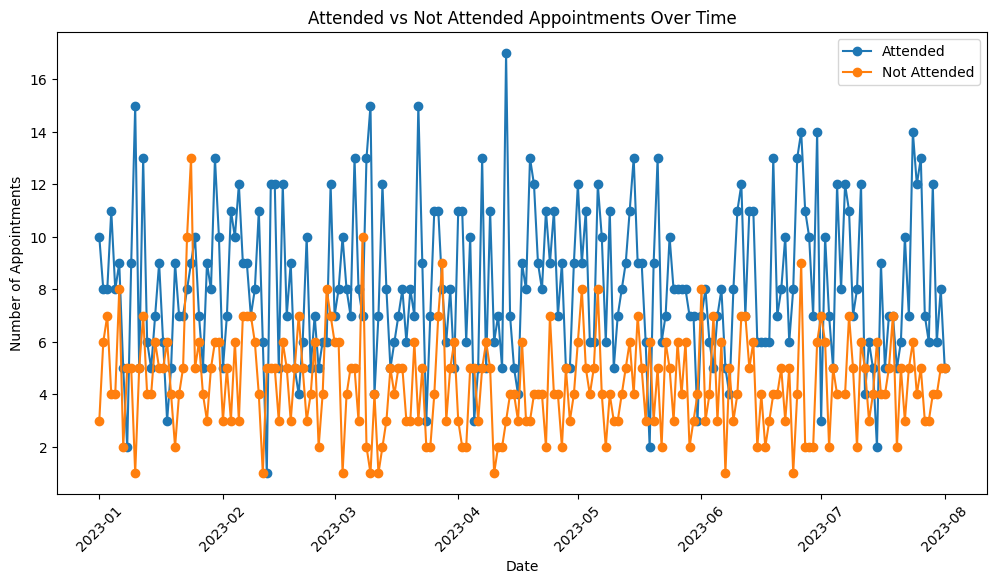

In [137]:
# Grouping by appointment_date and counting attended and not attended appointments
attended_by_date = appointments_data[appointments_data['appointment_status'] == 'Attended'].groupby('appointment_date').size()
not_attended_by_date = appointments_data[appointments_data['appointment_status'] != 'Attended'].groupby('appointment_date').size()

# Creating a chart with both attended and not attended counts over time
plt.figure(figsize=(12, 6))

# Plot for attended appointments
plt.plot(attended_by_date.index, attended_by_date, label='Attended', marker='o')

# Plot for not attended appointments
plt.plot(not_attended_by_date.index, not_attended_by_date, label='Not Attended', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of Appointments')
plt.title('Attended vs Not Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.show()


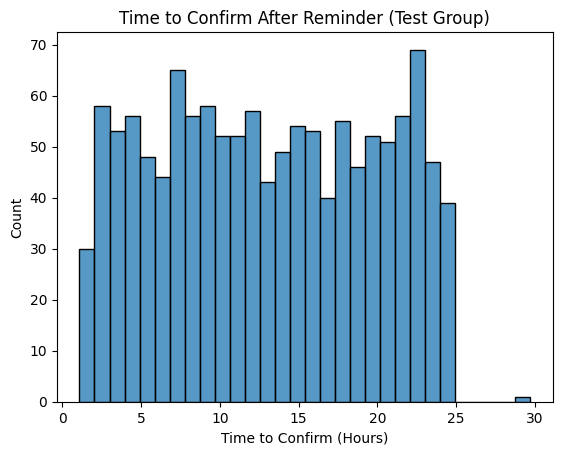

In [141]:
import seaborn as sns
# Merge A/B Test Data with Appointments Data
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Ensure 'event_datetime' is in datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Filter Test group data
test_group = merged_data[merged_data['group'] == 'Test']

# Identify the reminder_sent and appointment_confirmed events for each patient
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge to calculate time difference between reminder_sent and appointment_confirmed
reminder_confirmed = pd.merge(reminder_sent[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_sent', '_appointment_confirmed'))

# Calculate the time difference in hours
reminder_confirmed['time_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Plot the distribution of time to confirm after reminder
sns.histplot(reminder_confirmed['time_to_confirm'], bins=30)
plt.title('Time to Confirm After Reminder (Test Group)')
plt.xlabel('Time to Confirm (Hours)')
plt.show()


In [99]:
# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Convert event_datetime to datetime format
test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])

# Pivot the Test group data to have event types as columns
pivoted_test = test_group.pivot(index='patient_id', columns='event_name', values='event_datetime')

# Calculate time difference between reminder_sent and reminder_viewed
pivoted_test['response_time_to_view'] = (pivoted_test['reminder_viewed'] - pivoted_test['reminder_sent']).dt.total_seconds() / 3600

# Calculate time difference between reminder_sent and appointment_confirmed
pivoted_test['response_time_to_confirm'] = (pivoted_test['appointment_confirmed'] - pivoted_test['reminder_sent']).dt.total_seconds() / 3600

# Filter out patients with missing times
response_times = pivoted_test[['response_time_to_view', 'response_time_to_confirm']].dropna()

# Output the average response times
average_time_to_view = response_times['response_time_to_view'].mean()
average_time_to_confirm = response_times['response_time_to_confirm'].mean()

print(f"Average Time to View Reminder: {average_time_to_view:.2f} hours")
print(f"Average Time to Confirm Appointment: {average_time_to_confirm:.2f} hours")

Average Time to View Reminder: 12.52 hours
Average Time to Confirm Appointment: 13.06 hours


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/2154243314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])


In [89]:
# Create columns for day of the week and hour of the day
pivoted_test['reminder_sent_day'] = pivoted_test['reminder_sent'].dt.day_name()
pivoted_test['reminder_sent_hour'] = pivoted_test['reminder_sent'].dt.hour

pivoted_test['appointment_confirmed_day'] = pivoted_test['appointment_confirmed'].dt.day_name()
pivoted_test['appointment_confirmed_hour'] = pivoted_test['appointment_confirmed'].dt.hour

# Analyze the response time by day of the week (use a list for columns)
daywise_response = pivoted_test.groupby('reminder_sent_day')[['response_time_to_view', 'response_time_to_confirm']].mean()

# Analyze the response time by hour of the day (use a list for columns)
hourwise_response = pivoted_test.groupby('reminder_sent_hour')[['response_time_to_view', 'response_time_to_confirm']].mean()

print(f"\nResponse Time by Day of the Week:\n{daywise_response}")
print(f"\nResponse Time by Hour of the Day:\n{hourwise_response}")



Response Time by Day of the Week:
event_name         response_time_to_view  response_time_to_confirm
reminder_sent_day                                                 
Friday                         12.776502                 13.377693
Monday                         12.412976                 12.878694
Saturday                       11.208312                 11.605397
Sunday                         12.565004                 13.010241
Thursday                       13.419092                 13.992461
Tuesday                        12.771843                 13.340025
Wednesday                      12.429656                 13.070764

Response Time by Hour of the Day:
event_name          response_time_to_view  response_time_to_confirm
reminder_sent_hour                                                 
0.0                             10.875803                 11.377088
1.0                             12.727978                 13.486480
2.0                             10.662875              

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/3676263062.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}


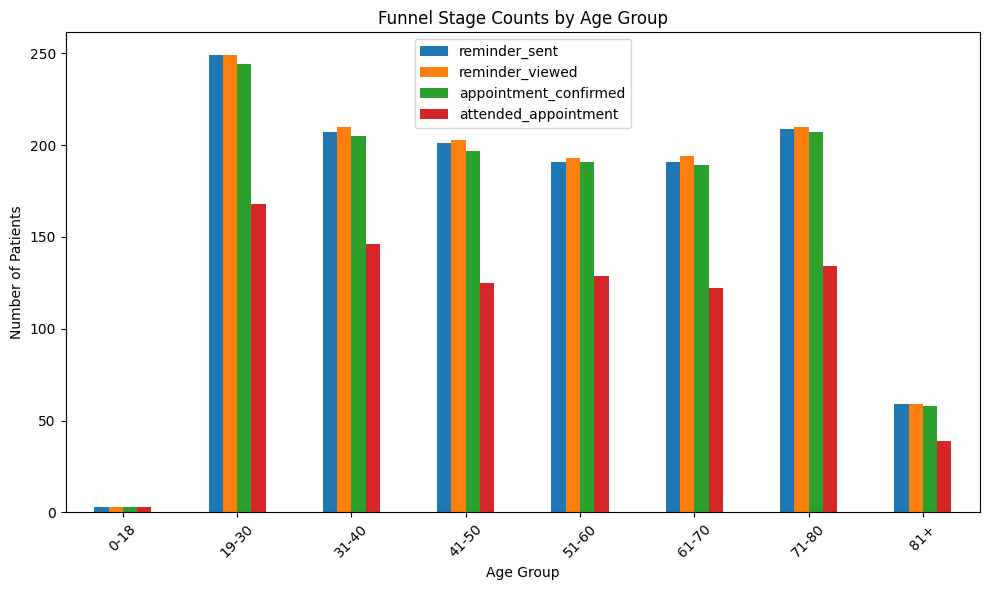

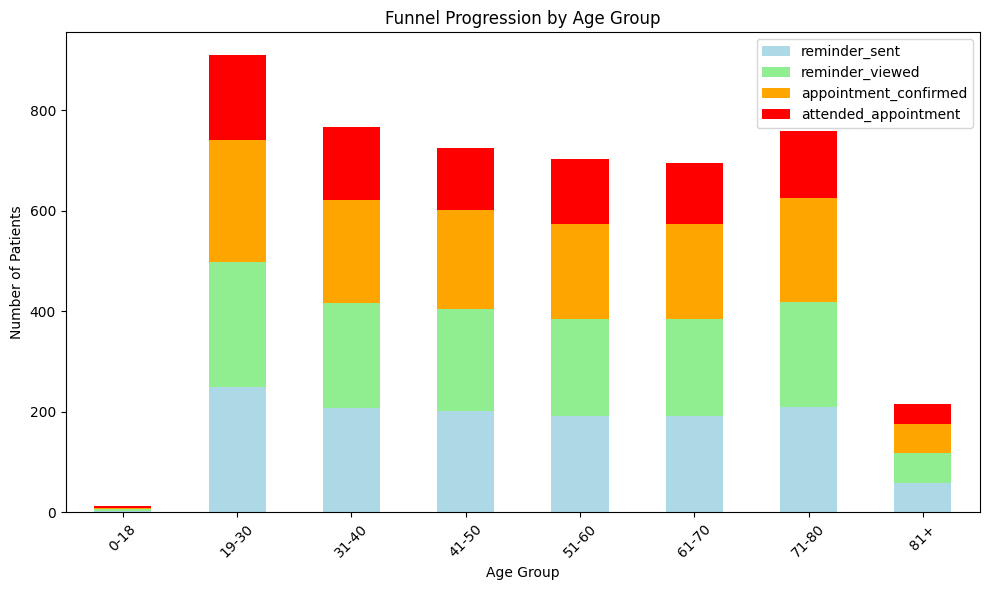

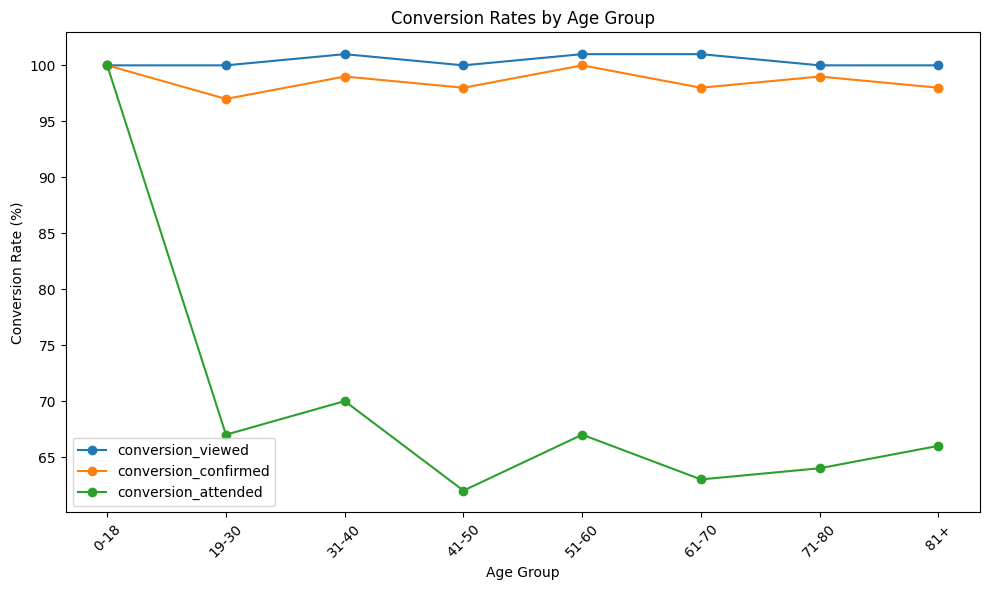

In [132]:
# Load dataset (assuming ab_appointments_merged is already loaded as a DataFrame)
df = ab_appointments_merged.copy()
df = df[df['group'] == 'Test']
# Define age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Step 1: Analyze funnel stages by age group
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Create a dictionary to store funnel counts for each stage
funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}

# Convert the funnel_counts dictionary to a DataFrame 
funnel_df = pd.DataFrame(funnel_counts).fillna(0)  
# Fill missing values with 0

# Step 2: Calculate conversion rates for each age group
funnel_df['conversion_viewed'] = (funnel_df['reminder_viewed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_confirmed'] = (funnel_df['appointment_confirmed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_attended'] = (funnel_df['attended_appointment'] / funnel_df['reminder_sent']) * 100

# Step 3: Display the funnel data for each age group
funnel_df = funnel_df[['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment', 'conversion_viewed', 'conversion_confirmed', 'conversion_attended']]
funnel_df = funnel_df.astype(int, errors='ignore')  # Convert counts to integer for cleaner display

# Bar chart for Funnel Stage Counts
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_df[funnel_stages].plot(kind='bar', figsize=(10, 6))
plt.title('Funnel Stage Counts by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stacked bar chart for Funnel Progression
funnel_df[funnel_stages].plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightgreen', 'orange', 'red'])
plt.title('Funnel Progression by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line chart for Conversion Rates
conversion_columns = ['conversion_viewed', 'conversion_confirmed', 'conversion_attended']
funnel_df[conversion_columns].plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Conversion Rates by Age Group')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
